# Statistics and Machine Learning

Some operations are especially useful for statistics

- `get_dummies`
- `from_dummies` ([someday](https://github.com/pydata/pandas/issues/8745)?)
- `factorize`
- `sample`
- ...

Note: not talking about your `mean`s and `std`s here.

It's quite common to have categorical data (in the statistical sense), which must be transformed before putting them into an algorithm. There are a couple ways to handle this.

### Factorization

This basically creates a mapping between the categories and integers. This sometimes makes sense if you're representing soemthing like responses to a survey where the responses are `bad`, `neutral` and `good`.

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
%matplotlib inline

In [4]:
s = pd.Series(pd.Categorical(np.random.choice(['bad', 'neutral', 'good'], size=40),
                             categories=['bad', 'neutral', 'good'], ordered=True))
s

0        good
1        good
2        good
3        good
4         bad
       ...   
35        bad
36    neutral
37       good
38    neutral
39    neutral
dtype: category
Categories (3, object): [bad, neutral, good]

In [5]:
s.cat.codes

0     2
1     2
2     2
3     2
4     0
     ..
35    0
36    1
37    2
38    1
39    1
dtype: int8

In [6]:
df = pd.concat([pd.DataFrame(np.random.randn(40, 3), columns=list('abc')),
                s],
               axis=1)
df

,a,b,c,0
0,-0.722144,0.980724,-1.494301,good
1,0.628989,-0.599043,-0.391020,good
2,0.592416,-0.082583,0.450977,good
3,-0.057457,-0.657297,-1.339352,good
4,-1.541161,-0.514983,0.454504,bad
...,...,...,...,...
35,0.107393,-1.090957,1.288496,bad
36,-1.589196,1.402376,-0.379823,neutral
37,1.099229,0.042913,0.300139,good
38,0.014713,0.192659,0.601258,neutral


This can potentially be misleading. If you feed it into something like OLS it implies that the "distance" between `bad` and `neutral` is the same as between `neutral` and `good`.

In [237]:
iris = datasets.load_iris()

X = iris['data']
y = iris['target']
feature_names = iris['feature_names']
target_names = iris['target_names']


In [240]:
pd.DataFrame(X, columns=feature_namesdd)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [171]:
import statsmodels.api as sm

In [ ]:
TODO: str.get_dummies

# Integration with other libraries

The two foundational libraries for stats in python are statsmodels and scikit-learn.
Everyone speaks *lingua franca* of NumPy arrays, but there is some integration at the higher level of DataFrames.

# Statsmodels

Brief primer: you give a **estimator** (OLS, WLS, GLM) a **formula** and **dataset**. You then fit that model. The integration with pandas here is fantastic.

http://nbviewer.ipython.org/urls/umich.box.com/shared/static/zyl08wsmxwoh6ts70v4o.ipynb?


In [100]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_rows = 10

We've got some longintudinal data (repeated measures of the same individual on children with HIV. There are two treatment arms, and each child receives an anti-retroviral theropy or are  in the control. Here's the data:

In [101]:
df = pd.read_csv('data/cd4.csv', parse_dates=['VDATE'], index_col=['newpid', 'VISIT'])
df = df.dropna()  # estimator can't handle NaNs so ignore for now.
df.head()

VDATE  CD4PCT  arv  treatmnt  CD4CNT  baseage
newpid VISIT                                                   
1      1     1988-06-29      18    0         1     323     3.91
       4     1989-01-19      37    0         1     610     3.91
       7     1989-04-13      13    0         1     324     3.91
       13    1989-11-30      13    0         1     626     3.91
       19    1990-06-07      12    1         1     220     3.91

Some basic statistics:

In [102]:
df.assign(cnt=1).groupby(['arv', 'treatmnt']).cnt.sum().unstack()

treatmnt,1,2
arv,,
0,486,402
1,48,42


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 978 entries, (1, 1) to (254, 7)
Data columns (total 6 columns):
VDATE       978 non-null datetime64[ns]
CD4PCT      978 non-null float64
arv         978 non-null float64
treatmnt    978 non-null int64
CD4CNT      978 non-null float64
baseage     978 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 50.9+ KB


In [104]:
df.groupby('arv').CD4CNT.mean()

arv
0    947.930180
1    926.166667
Name: CD4CNT, dtype: float64

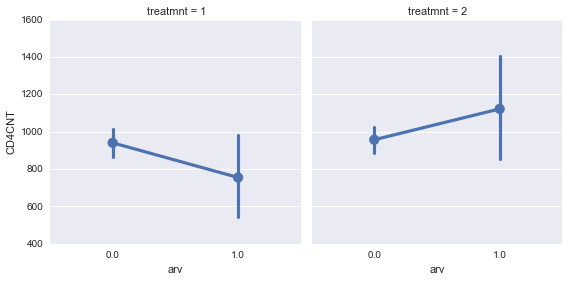

In [105]:
sns.factorplot(x='arv', y='CD4CNT', col='treatmnt', data=df)

In [109]:
gr = df.groupby(level='newpid').VDATE
x = gr.get_group(1)
x

newpid  VISIT
1       1       1988-06-29
        4       1989-01-19
        7       1989-04-13
        13      1989-11-30
        19      1990-06-07
Name: VDATE, dtype: datetime64[ns]

In [117]:
(x - x.min()).dt.days // 365

newpid  VISIT
1       1        0
        4        0
        7        0
        13       1
        19       1
dtype: int64

In [124]:
years_since = df.groupby(level='newpid').VDATE.apply(lambda x: (x - x.min()).dt.days / 365)
df['age'] = df.baseage + years_since

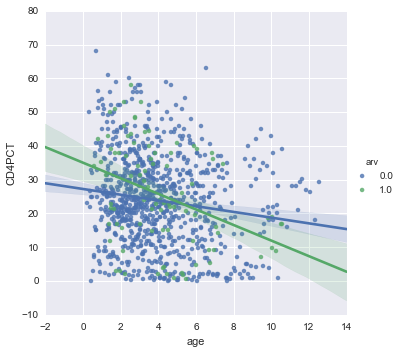

In [125]:
sns.lmplot("age", "CD4PCT", data=df, hue="arv")

These statistics are throwing away information. They don't tie one observation of an individual to the second observation *of the same individual*. We'd expect some people to consistently have higher or lower `CD4PCT` than others. We'll use a GEE model, but we have to extract the age at the time of each observation to get there.

In [126]:
mod_basic = sm.GEE.from_formula("CD4PCT ~ age + arv + treatmnt", "newpid", df.reset_index())
res_basic = mod_basic.fit()
res_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      CD4PCT   No. Observations:                  978
Model:                                 GEE   No. clusters:                      226
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 4.3
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sat, 18 Jul 2015   Scale:                         171.820
Covariance type:                    robust   Time:                         18:20:34
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     23.9086      2.997      7.977      0.000        18.034    29.783
age           -0.9923      0.373     -2.661      0.008        -1.723    -0.261
arv            1.6919      2.070      0.817      0.414        -2.365     5.749
treatmnt       2.7020      1.635      1.653      0.098        -0.503     5.907
==============================================================================
Skew:                          0.2773   Kurtosis:                      -0.3432
Centered skew:                 0.2924   Centered kurtosis:              3.2945
==============================================================================
"""

In [127]:
ex = sm.cov_struct.Exchangeable()
mod_exchangable = sm.GEE.from_formula("CD4PCT ~ age + arv + treatmnt", "newpid", df.reset_index(),
                                      cov_struct=ex)
res_exchangable = mod_exchangable.fit()
res_exchangable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      CD4PCT   No. Observations:                  978
Model:                                 GEE   No. clusters:                      226
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 4.3
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Sat, 18 Jul 2015   Scale:                         175.419
Covariance type:                    robust   Time:                         18:20:35
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     27.4284      2.801      9.792      0.000        21.939    32.918
age           -1.7609      0.336     -5.244      0.000        -2.419    -1.103
arv            1.9451      1.181      1.647      0.100        -0.369     4.260
treatmnt       1.9567      1.569      1.247      0.212        -1.119     5.032
==============================================================================
Skew:                          0.2521   Kurtosis:                      -0.3788
Centered skew:                 0.2914   Centered kurtosis:              3.3861
==============================================================================
"""

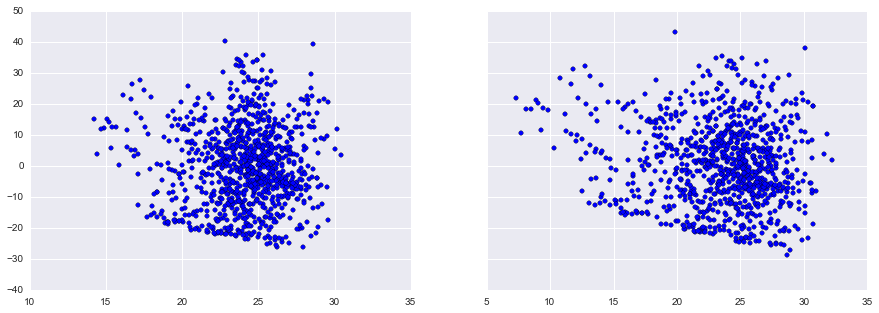

In [128]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2, sharey=True)
axes[0].scatter(res_basic.fittedvalues, res_basic.resid)
axes[1].scatter(res_exchangable.fittedvalues, res_exchangable.resid)

In [129]:
ar = sm.cov_struct.Autoregressive()
mod_ar = sm.GEE.from_formula("CD4PCT ~ age + arv + treatmnt", "newpid", data=df.reset_index(), 
                             time="age", cov_struct=ar)
res_ar = mod_ar.fit()
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      CD4PCT   No. Observations:                  978
Model:                                 GEE   No. clusters:                      226
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 4.3
Dependence structure:       Autoregressive   Num. iterations:                    12
Date:                     Sat, 18 Jul 2015   Scale:                         171.898
Covariance type:                    robust   Time:                         18:20:37
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     24.3002      2.861      8.493      0.000        18.693    29.908
age           -1.0563      0.356     -2.963      0.003        -1.755    -0.358
arv            2.2118      1.370      1.615      0.106        -0.473     4.896
treatmnt       2.4728      1.576      1.569      0.117        -0.616     5.562
==============================================================================
Skew:                          0.2707   Kurtosis:                      -0.3444
Centered skew:                 0.2975   Centered kurtosis:              3.2915
==============================================================================
"""

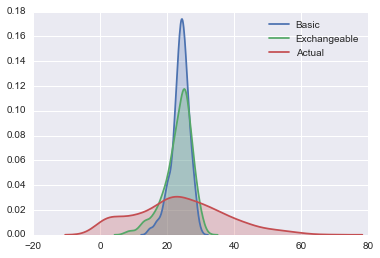

In [131]:
sns.kdeplot(res_basic.fittedvalues, shade=True, label='Basic')
sns.kdeplot(res_exchangable.fittedvalues, shade=True, label='Exchangeable')
sns.kdeplot(df.CD4PCT, shade=True, label='Actual')

# Scikit-learn

In [3]:
from sklearn.datasets import california_housing
data = california_housing.fetch_california_housing()

In [75]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [41]:
%%time
param_grid = dict(
    max_features=np.arange(2, 8),
    max_depth=[2, 4],
    min_samples_split=[5, 10, 15, 20],
)
rfc = RandomForestRegressor(n_estimators=10)
gs = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
gs.fit(X.values, y.values)

CPU times: user 1.57 s, sys: 142 ms, total: 1.71 s
Wall time: 16.8 s


In [43]:
scores = gs.grid_scores_

In [49]:
row = scores[0]

In [58]:
    params = sorted(scores[0].parameters)

In [59]:
row.parameters[params[0]]

2

In [60]:
def unpack_grid_scores(scores):
    rows = []
    params = sorted(scores[0].parameters)
    for row in scores:
        mean = row.mean_validation_score
        std = row.cv_validation_scores.std()
        rows.append([mean, std] + [row.parameters[k] for k in params])
    return pd.DataFrame(rows, columns=['mean_', 'std_'] + params)

In [62]:
scores = unpack_grid_scores(gs.grid_scores_)

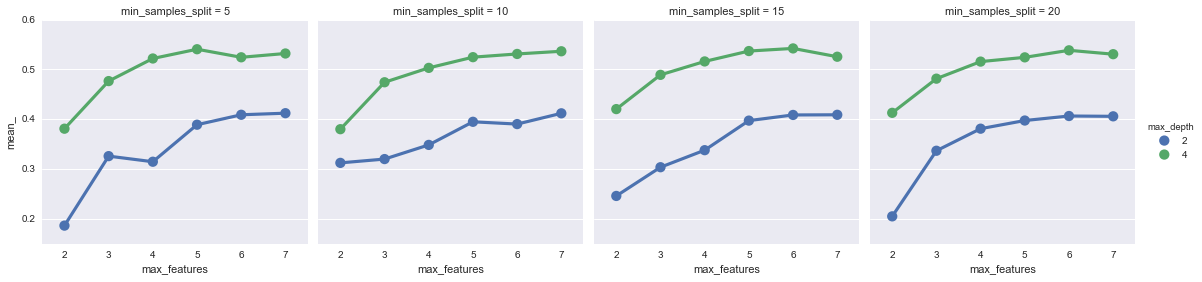

In [70]:
sns.factorplot(x='max_features', y='mean_', hue='max_depth', col='min_samples_split', data=scores)

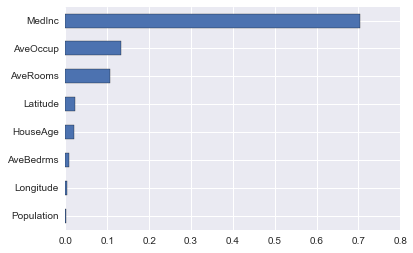

In [74]:
pd.Series(gs.best_estimator_.feature_importances_, index=X.columns).order().plot(kind='barh')